In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import boto3
import sagemaker
import pandas as pd

from sagemaker import get_execution_role
role = get_execution_role()
sagemaker_session = sagemaker.Session()
sagemaker_client = boto3.client('sagemaker')

In [ ]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00445/Absenteeism_at_work_AAA.zip'
s3_prefix = 'aws-machine-learning-specialty/algorithms/k-means/clustering'
s3_bucket = sagemaker_session.default_bucket()

### Download Dataset 

In [3]:
!wget -P . $dataset_url 
local_filename = dataset_url.split('/')[-1]
!unzip $local_filename  
!rm $local_filename

--2021-01-31 14:41:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/00445/Absenteeism_at_work_AAA.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66136 (65K) [application/x-httpd-php]
Saving to: ‘./Absenteeism_at_work_AAA.zip’

Absenteeism_at_work 100%[===================>]  64.59K  --.-KB/s    in 0.1s    

2021-01-31 14:41:09 (460 KB/s) - ‘./Absenteeism_at_work_AAA.zip’ saved [66136/66136]

Archive:  Absenteeism_at_work_AAA.zip
  inflating: Absenteeism_at_work.arff  
  inflating: Absenteeism_at_work.csv  
  inflating: Absenteeism_at_work.xls  
  inflating: Attribute Information.docx  
  inflating: UCI_ABS_TEXT.docx       


In [3]:
absence = pd.read_csv('Absenteeism_at_work.csv',delimiter=";")
absence.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


In [4]:
absence = absence.drop(['ID'], axis=1)
absence.shape

(740, 20)

In [5]:
absence.dropna(inplace=True)
absence.shape

(740, 20)

In [6]:
absence.index=absence['Reason for absence']
absence.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
Reason for absence,,,,,,,,,,,,,,,,,,,,
26,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
0,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
23,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
23,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [7]:
absence.shape

(740, 20)

### Visualizaciones

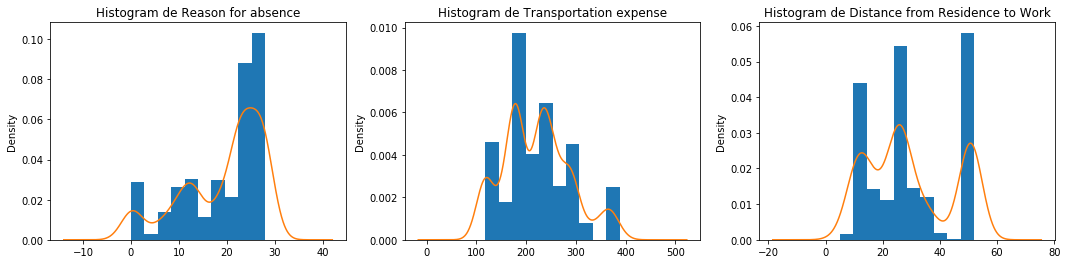

In [8]:
fig, ax = plt.subplots(1,3, figsize=(18,4))
axf = ax.flatten()
for i,a in enumerate(['Reason for absence', 'Transportation expense', 'Distance from Residence to Work']):
    absence[a].plot.hist(ax=axf[i], density=True)
    absence[a].plot.kde(ax=axf[i])
    axf[i].set_title('Histogram de '+ a, fontsize=12)
    

### Preprocessing

Hay que estandarizar las columnas para calcular distancias correctamente.
MinMaxScaler transforma las columnas entre 0 y 1

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
absence_scaled=pd.DataFrame(scaler.fit_transform(absence))
absence_scaled.columns=absence.columns
absence_scaled.index=absence.index

In [10]:
absence_scaled.describe()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,0.686293,0.527027,0.478716,0.514865,0.382703,0.524066,0.412645,0.304839,0.379108,0.715149,0.054054,0.097297,0.254730,0.567568,0.072973,0.093243,0.442983,0.276208,0.404054,0.057703
std,0.301193,0.286357,0.355419,0.370610,0.247971,0.315676,0.156603,0.208993,0.225813,0.198911,0.226277,0.224413,0.274622,0.495749,0.260268,0.164782,0.247754,0.182879,0.225550,0.111092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.464286,0.250000,0.250000,0.333333,0.225926,0.234043,0.285714,0.129032,0.222412,0.631579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.181818,0.263158,0.016667
50%,0.821429,0.500000,0.500000,0.666667,0.396296,0.446809,0.428571,0.322581,0.337244,0.736842,0.000000,0.000000,0.250000,1.000000,0.000000,0.000000,0.519231,0.212121,0.315789,0.025000
75%,0.928571,0.750000,0.750000,1.000000,0.525926,0.957447,0.535714,0.419355,0.510502,0.842105,0.000000,0.000000,0.500000,1.000000,0.000000,0.125000,0.634615,0.272727,0.631579,0.066667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Principal Component Analysis (PCA de Sagemaker)

In [13]:
from sagemaker import PCA
num_components=19
pca_output = 's3://{}/{}/absence/'.format(s3_bucket, s3_prefix)

pca_SM = PCA(role=role,
             instance_count=1,
             instance_type='ml.c4.xlarge',
             output_path=pca_output,
             num_components=num_components)

train_data = absence_scaled.values.astype('float32')

In [14]:
%%time
pca_SM.fit(pca_SM.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-02-01 00:58:14 Starting - Starting the training job...
2021-02-01 00:58:38 Starting - Launching requested ML instancesProfilerReport-1612141094: InProgress
.........
2021-02-01 00:59:58 Starting - Preparing the instances for training...
2021-02-01 01:00:40 Downloading - Downloading input data...
2021-02-01 01:00:59 Training - Downloading the training image...
2021-02-01 01:01:45 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
[02/01/2021 01:01:42 INFO 140510342133568] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[02/01/2021 01:01:42 INFO 140510342133568] Merging with provided configuration fro

Obtenemos los artefactos del modelo entrenado utilizando la API de Sagemaker

In [21]:
#el último trainin job debería ser el nuestro

tjs = sagemaker_client.list_training_jobs(
    NameContains='pca',
    SortBy='CreationTime',
    SortOrder='Descending')

tj_name = tjs['TrainingJobSummaries'][0]['TrainingJobName']
print('Trainin Job Name:',tj_name)

tj_details = sagemaker_client.describe_training_job(
    TrainingJobName=tj_name
)
tj_model_artifacts = tj_details['ModelArtifacts']['S3ModelArtifacts']
print('Model Artifacts in', tj_model_artifacts)

Trainin Job Name: pca-2021-02-01-00-58-14-771
Model Artifacts in s3://sagemaker-us-east-1-844626608976/aws-machine-learning-specialty/algorithms/k-nn/clustering/absence/pca-2021-02-01-00-58-14-771/output/model.tar.gz


Descargamos el modelo entrenado a local

In [29]:
file_name = tj_model_artifacts.split('/')[-1]
model_key = '/'.join(tj_model_artifacts.split('/')[3:])
boto3.resource('s3').Bucket(s3_bucket).download_file(model_key, file_name)
os.system('tar -zxvf {}'.format(file_name))

0

Y cargamos el mmodelo usando Mxnet

In [32]:
#!pip install mxnet

In [33]:
import mxnet as mx
pca_model_params = mx.ndarray.load('model_algo-1')

In [34]:
# Exact explained-variance-ratio vector
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [42]:
# Calculate the variance explained by the largest n components that we want to keep. 
# Take the top 5 components
# The largest 5 components explain ~62% of the total variance in our dataset
s.iloc[14:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.622284
dtype: float32

In [44]:
# After keeping the top 5 components take only the 5 largest components from original s and v matrix
s_5=s.iloc[14:,:]
v_5=v.iloc[:,14:]
v_5.columns=[0,1,2,3,4]
v_5.head()

,0,1,2,3,4
0,0.407281,-0.448665,0.193074,0.289915,-0.059501
1,0.217295,-0.079499,-0.023497,-0.452234,-0.036570
2,-0.584830,-0.525670,0.547078,-0.047001,-0.035020
3,0.160280,-0.319543,-0.043324,-0.762302,0.045018
4,0.098019,0.332768,0.286093,-0.152991,-0.065728


Examinemos la composición de uno de los componentes de PCA basándonos en los pesos de las características originales.

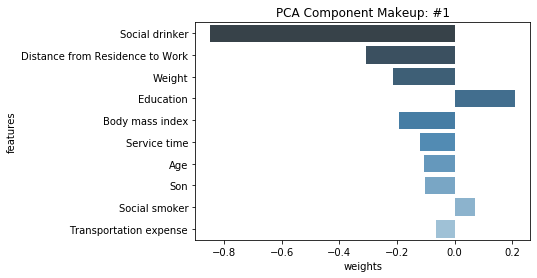

In [45]:
component_num=1
first_comp = v_5[5-component_num]
comps = pd.DataFrame(list(zip(first_comp, absence_scaled.columns)), columns=['weights', 'features'])
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
ax=sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

#### Despliegue del modelo PCA

In [46]:
pca_from_job = sagemaker.estimator.Estimator.attach(tj_name,sagemaker_session=sagemaker_session)
pca_predictor = pca_from_job.deploy(initial_instance_count=1,instance_type='ml.t2.medium')


2021-02-01 01:02:41 Starting - Preparing the instances for training
2021-02-01 01:02:41 Downloading - Downloading input data
2021-02-01 01:02:41 Training - Training image download completed. Training in progress.
2021-02-01 01:02:41 Uploading - Uploading generated training model
2021-02-01 01:02:41 Completed - Training job completed
---------------------!

In [59]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

pca_predictor.ContentType = "text/csv"
pca_predictor.serializer = CSVSerializer()
pca_predictor.deserializer = JSONDeserializer()

#### Calculamos los components pricipales del dataset

In [60]:
result = pca_predictor.predict(train_data)

In [74]:
#creamos un listado donde para cada razón se explica la causa en virtud del PCA
PCA_list=['Social drinker', 'Distance from Residence to Work', 'Weight', 'Education', 'Body mass index']
absence_transformed=pd.DataFrame()
for a in result['projections']:
    b=a['projection']
    absence_transformed=absence_transformed.append([list(b)])
absence_transformed.index=absence_scaled.index
absence_transformed=absence_transformed.iloc[:,14:]
absence_transformed.columns=PCA_list

In [75]:
absence_transformed.head()

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index
Reason for absence,,,,,
26,0.220163,0.277262,0.023891,0.416488,-0.574165
0,-0.813139,0.473745,-0.941796,0.071819,-0.446411
23,0.119235,-0.130268,-0.052720,0.539152,-0.643213
7,-0.839607,0.590692,0.207264,0.134280,-0.147293
23,-0.115692,0.061643,0.277216,0.362107,-0.585175


Para el proximo paso utilizamos los top 5 componentes como la data de entrenamiento.

In [76]:
train_data = absence_transformed.values.astype('float32')

#### K-Means Clustering

In [79]:
# Econtraremos los top 7 cluster del dataset
from sagemaker import KMeans

kmeans_output = 's3://{}/{}/absence/'.format(s3_bucket, s3_prefix)
num_clusters = 7

kmeans = KMeans(role=role,
                instance_count=1,
                instance_type='ml.c4.xlarge',
                output_path=kmeans_output,              
                k=num_clusters)

In [80]:
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-02-01 02:30:33 Starting - Starting the training job...
2021-02-01 02:30:56 Starting - Launching requested ML instancesProfilerReport-1612146633: InProgress
.........
2021-02-01 02:32:17 Starting - Preparing the instances for training...
2021-02-01 02:32:58 Downloading - Downloading input data
2021-02-01 02:32:58 Training - Downloading the training image......
2021-02-01 02:34:00 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[02/01/2021 02:33:57 INFO 140299538753344] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001',

#### Desplegamos el modelo entrenado para inferencias

In [81]:
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!

#### Realizamos la predicción de los clusteres

In [82]:
result=kmeans_predictor.predict(train_data)

In [84]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

In [85]:
pd.DataFrame(cluster_labels)[0].value_counts()

5.0    131
2.0    130
0.0    129
3.0     96
1.0     93
4.0     92
6.0     69
Name: 0, dtype: int64

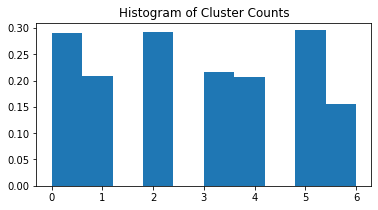

In [93]:
fig, ax=plt.subplots(figsize=(6,3))
ax.hist(cluster_labels, density=True)
ax.set_title("Histogram of Cluster Counts", fontsize=12);

In [94]:
#el último trainin job debería ser el nuestro

tjs = sagemaker_client.list_training_jobs(
    SortBy='CreationTime',
    SortOrder='Descending')

tj_name = tjs['TrainingJobSummaries'][0]['TrainingJobName']
print('Trainin Job Name:',tj_name)

tj_details = sagemaker_client.describe_training_job(
    TrainingJobName=tj_name
)
tj_model_artifacts = tj_details['ModelArtifacts']['S3ModelArtifacts']
print('Model Artifacts in', tj_model_artifacts)

Trainin Job Name: kmeans-2021-02-01-02-30-33-324
Model Artifacts in s3://sagemaker-us-east-1-844626608976/aws-machine-learning-specialty/algorithms/k-nn/clustering/absence/kmeans-2021-02-01-02-30-33-324/output/model.tar.gz


In [95]:
# Access the underlying model to get the cluster centers
# Centers will help describe which features characterize each cluster
# First retrieve the K-Means model attributes
file_name = tj_model_artifacts.split('/')[-1]
model_key = '/'.join(tj_model_artifacts.split('/')[3:])

boto3.resource('s3').Bucket(s3_bucket).download_file(model_key, file_name)
os.system('tar -zxvf {}'.format(file_name))

0

In [96]:
Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [97]:
# Cluster Centroid Locations: The location of the centers of each cluster identified by the Kmeans algorithm
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=absence_transformed.columns
cluster_centroids

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index
0,0.021989,0.251883,0.291805,0.118640,-0.455986
1,-0.027010,-0.136308,0.369848,0.268204,0.710736
2,0.063673,-0.145580,-0.136259,0.352843,-0.541232
3,0.183944,-0.152292,0.090549,-0.578525,-0.486041
4,0.121548,-0.180080,-0.088314,-0.516510,0.606680
5,-0.005665,0.118407,-0.163495,0.253738,0.586104
6,-0.522696,0.148271,-0.395738,-0.131416,-0.314201


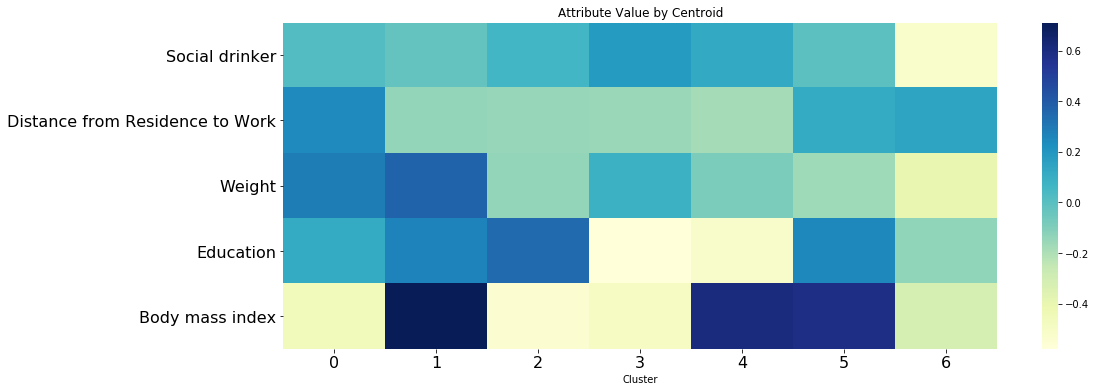

In [98]:
# Plot a heatmap of the centroids and their location in the transformed feature space
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [99]:
# Map the cluster labels back to each individual absenteeism and examine which were naturally grouped together
absence_transformed['labels']=list(map(int, cluster_labels))
absence_transformed.head()

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index,labels
Reason for absence,,,,,,
26,0.220163,0.277262,0.023891,0.416488,-0.574165,0
0,-0.813139,0.473745,-0.941796,0.071819,-0.446411,6
23,0.119235,-0.130268,-0.052720,0.539152,-0.643213,2
7,-0.839607,0.590692,0.207264,0.134280,-0.147293,6
23,-0.115692,0.061643,0.277216,0.362107,-0.585175,0


In [100]:
# Examine one of the clusters in more detail
cluster=absence_transformed[absence_transformed['labels']==1]
cluster.head(5)

,Social drinker,Distance from Residence to Work,Weight,Education,Body mass index,labels
Reason for absence,,,,,,
11,-0.243330,0.173077,0.283201,0.288298,0.503087,1
28,-0.394209,-0.164540,0.263402,0.394709,0.329208,1
23,0.520496,0.189885,0.255469,0.403811,0.571548,1
23,0.000691,-0.274872,0.497824,-0.040010,0.551605,1
23,0.069257,0.072046,0.240185,0.364077,0.604830,1


In [101]:
#### Delete Endpoints

In [106]:
sagemaker.Session().delete_endpoint(pca_predictor.endpoint_name)
sagemaker.Session().dele#te_endpoint(kmeans_predictor.endpoint_name)